In [ ]:
pip install "tensorflow<2.11"

In [ ]:
pip install keras-tuner

In [450]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from ast import literal_eval
import seaborn as sns
from scipy import stats

In [169]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, BatchNormalization, Reshape, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, RandomSearch, BayesianOptimization, GridSearch

### Data Processing

In [4]:
# Read the CSV file containing SVI parameters
# Use literal_eval to convert the 'moneyness' column from string representation to a list

param_data = pd.read_csv("../data/svi_param_dataset.csv", converters={'moneyness': literal_eval})
param_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
param_data

,timestamp,Time_To_Maturity,a,b,rho,m,sigma,moneyness
0,2024-08-10 11:04:14,0.005479,-0.110285,6.044639,-0.282334,-0.020460,0.038765,"[-0.17811509621369015, -0.15869701035658862, -..."
1,2024-08-10 11:04:14,0.008219,-0.763708,6.859500,-0.219764,-0.029368,0.134726,"[-0.13960759904564377, -0.12091546603349118, -..."
2,2024-08-10 11:04:14,0.010959,-32.118497,33.309849,-0.244934,-0.243195,1.000000,"[-0.12159774217227369, -0.10324860350407722, -..."
3,2024-08-10 11:04:14,0.019178,-2.499705,6.115576,0.017514,0.040952,0.448595,"[-0.42263469683531946, -0.3738445326658876, -0..."
4,2024-08-10 11:04:14,0.038356,-2.040586,3.777837,-0.031391,0.022585,0.607811,"[-0.42414308361269254, -0.3753529194432604, -0..."
...,...,...,...,...,...,...,...,...
2827,2024-08-10 22:00:04,0.210959,-0.806502,1.191507,-0.350800,-0.419225,1.000000,"[-0.9143085221939722, -0.7319869654000176, -0...."
2828,2024-08-10 22:00:04,0.249315,-0.520728,0.858675,-0.046216,-0.052637,1.000000,"[-0.44867148173590404, -0.33088844607952067, -..."
2829,2024-08-10 22:00:04,0.383562,-0.403187,0.758455,-0.109753,-0.136756,1.000000,"[-1.8509392831061022, -1.4454741749979378, -1...."
2830,2024-08-10 22:00:04,0.632877,0.018290,0.435681,0.453109,0.683348,1.000000,"[-1.1886491952348825, -0.7831840871267183, -0...."


In [5]:
param_data.dtypes

timestamp            object
Time_To_Maturity    float64
a                   float64
b                   float64
rho                 float64
m                   float64
sigma               float64
moneyness            object
dtype: object

Sets timestamp and time to maturity as the indexes of the dataset

In [6]:
param_data.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
param_data

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 11:04:14 0.005479          -0.110285   6.044639 -0.282334   
                    0.008219          -0.763708   6.859500 -0.219764   
                    0.010959         -32.118497  33.309849 -0.244934   
                    0.019178          -2.499705   6.115576  0.017514   
                    0.038356          -2.040586   3.777837 -0.031391   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 11:04:14 0.005479         -0.020460  0.038765   
                    0.008219         -0.029368  0.134726   
                    0.010959         -0.243195  1.000000   
                    0.019178          0.040952  0.448595   
                    0.038356          0.022585  0.607811   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.419225  1.000000   
                    0.249315         -0.052637  1.000000   
                    0.383562         -0.136756  1.000000   
                    0.632877          0.683348  1.000000   
                    0.882192          0.298585  1.000000   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 11:04:14 0.005479          [-0.17811509621369015, -0.15869701035658862, -...  
                    0.008219          [-0.13960759904564377, -0.12091546603349118, -...  
                    0.010959          [-0.12159774217227369, -0.10324860350407722, -...  
                    0.019178          [-0.42263469683531946, -0.3738445326658876, -0...  
                    0.038356          [-0.42414308361269254, -0.3753529194432604, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[2832 rows x 6 columns]

In [7]:
param_data_moneyness = param_data

In [8]:
param_data = param_data.drop("moneyness", axis=1)

In [9]:
param_data

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 11:04:14 0.005479          -0.110285   6.044639 -0.282334   
                    0.008219          -0.763708   6.859500 -0.219764   
                    0.010959         -32.118497  33.309849 -0.244934   
                    0.019178          -2.499705   6.115576  0.017514   
                    0.038356          -2.040586   3.777837 -0.031391   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 11:04:14 0.005479         -0.020460  0.038765  
                    0.008219         -0.029368  0.134726  
                    0.010959         -0.243195  1.000000  
                    0.019178          0.040952  0.448595  
                    0.038356          0.022585  0.607811  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.419225  1.000000  
                    0.249315         -0.052637  1.000000  
                    0.383562         -0.136756  1.000000  
                    0.632877          0.683348  1.000000  
                    0.882192          0.298585  1.000000  

[2832 rows x 5 columns]

In [10]:
param_data.index.get_level_values(1).unique()

Index([0.0054794520547945, 0.0082191780821917,  0.010958904109589,
       0.0191780821917808, 0.0383561643835616, 0.0575342465753424,
       0.1342465753424657,  0.210958904109589, 0.2493150684931507,
       0.3835616438356164, 0.6328767123287671, 0.8821917808219178],
      dtype='float64', name='Time_To_Maturity')

In [11]:
len(param_data.index.get_level_values(1).unique())

12

Data Splitting

In [12]:
def create_sequences(data, seq_length):
    xs, ys, y_indexes = [], [], []
    for i in range(0,len(data)-seq_length, seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length : (i+seq_length+seq_length)].values
        y_index = data.iloc[i+seq_length : (i+seq_length+seq_length)].index

        xs.append(x)
        ys.append(y)
        y_indexes.append(y_index)

    return np.array(xs), np.array(ys), np.array(y_indexes)

seq_length = len(param_data.index.get_level_values(1).unique()) 
X, y, y_indexes = create_sequences(param_data[['a', 'b', 'rho', 'm', 'sigma']], seq_length)

In [13]:
data_split_pct = 0.7
data_split_index = int(len(X)*data_split_pct)

In [14]:
X_train, X_test = X[:data_split_index] , X[data_split_index:] 
y_train, y_test = y[:data_split_index], y[data_split_index:]

In [15]:
X_train

array([[[-1.10285254e-01,  6.04463883e+00, -2.82333942e-01,
         -2.04601504e-02,  3.87651031e-02],
        [-7.63707752e-01,  6.85950004e+00, -2.19764350e-01,
         -2.93684083e-02,  1.34726222e-01],
        [-3.21184971e+01,  3.33098491e+01, -2.44934150e-01,
         -2.43195484e-01,  1.00000000e+00],
        ...,
        [-4.20683778e-01,  7.69900592e-01, -1.11262197e-01,
         -1.50724987e-01,  1.00000000e+00],
        [-9.28438375e-03,  4.08343171e-01,  2.17193796e-01,
          3.04126372e-01,  1.00000000e+00],
        [ 1.66794586e-01,  2.44438147e-01,  6.49581252e-02,
          9.83678636e-02,  1.00000000e+00]],

       [[-1.12167284e-01,  6.06187112e+00, -2.87849787e-01,
         -2.11379087e-02,  3.96401828e-02],
        [-9.40164593e-01,  7.30513156e+00, -1.99080109e-01,
         -2.82755673e-02,  1.51100254e-01],
        [-2.26762225e+01,  2.79561258e+01, -2.40728907e-01,
         -1.99479233e-01,  8.42259534e-01],
        ...,
        [-4.17864708e-01,  7.6782777

In [16]:
X_test

array([[[ 9.64642361e-02,  4.65678118e+00, -2.84991333e-01,
         -1.08464030e-02,  1.33726732e-02],
        [-5.93066150e-02,  3.93307651e+00, -1.22246190e-01,
          8.33284434e-03,  6.17677585e-02],
        [-2.28562647e+01,  2.37991461e+01, -2.40321046e-01,
         -2.34925524e-01,  1.00000000e+00],
        ...,
        [-4.15843707e-01,  7.68390719e-01, -1.16474827e-01,
         -1.61151481e-01,  1.00000000e+00],
        [-3.23810776e-03,  4.08056169e-01,  2.53017301e-01,
          3.50156482e-01,  1.00000000e+00],
        [ 2.01394117e-01,  2.21539496e-01,  2.29387789e-01,
          2.96550940e-01,  1.00000000e+00]],

       [[ 1.01245652e-01,  4.61504522e+00, -2.81809408e-01,
         -1.01347299e-02,  1.24918305e-02],
        [-3.72429882e-02,  3.86962010e+00, -1.51606611e-01,
          5.57646665e-03,  5.70475739e-02],
        [-2.25140441e+01,  2.34454262e+01, -2.39843361e-01,
         -2.34799801e-01,  1.00000000e+00],
        ...,
        [-4.16888461e-01,  7.6898270

In [17]:
y_test_indexes= y_indexes[data_split_index:]

Scales the train and test data

In [18]:
def scale_dataset(train_data:np.ndarray, test_data:np.ndarray):
    scaled_train_data = []
    scaled_test_data = []
    scalers = []

    for i in range(5):
        scaler = MinMaxScaler()

        train_ith_feature = train_data[:, :, i]
        test_ith_feature = test_data[:, :, i]

        scaler.fit(train_ith_feature)

        scaled_train_ith_feature = scaler.transform(train_ith_feature)
        scaled_test_ith_feature = scaler.transform(test_ith_feature)

        scaled_train_data.append(scaled_train_ith_feature)
        scaled_test_data.append(scaled_test_ith_feature)
        scalers.append(scaler)

    scaled_train_data = np.stack(scaled_train_data, axis=-1).reshape(train_data.shape)
    scaled_test_data = np.stack(scaled_test_data, axis=-1).reshape(test_data.shape)

    return scaled_train_data, scaled_test_data, scalers

In [19]:
X_train_scaled, X_test_scaled, X_scalers = scale_dataset(X_train, X_test)
y_train_scaled, y_test_scaled, y_scalers = scale_dataset(y_train, y_test)

In [20]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[-2], X_train_scaled.shape[-1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[-2], X_test_scaled.shape[-1], 1)

In [21]:
X_train_scaled

array([[[[[0.0471905 ],
          [0.97513247],
          [0.89438175],
          [0.15881215],
          [0.94732452]],

         [[0.76709407],
          [0.3137058 ],
          [0.68617923],
          [0.72934926],
          [0.40348529]],

         [[0.05467478],
          [0.21545642],
          [0.98435006],
          [0.01758319],
          [1.        ]],

         ...,

         [[0.        ],
          [0.92735217],
          [0.52995159],
          [0.52901605],
          [0.        ]],

         [[0.1345174 ],
          [0.2767708 ],
          [0.21670303],
          [0.21401724],
          [1.        ]],

         [[0.50576159],
          [0.29870832],
          [0.69386468],
          [0.72369738],
          [1.        ]]]],



       [[[[0.03751361],
          [0.98890403],
          [0.81934708],
          [0.08223737],
          [0.97724205]],

         [[0.71547462],
          [0.35626076],
          [0.74153565],
          [0.73721538],
          [0.471538  ]],

     

In [22]:
y_test[:100]

array([[[ 1.01245652e-01,  4.61504522e+00, -2.81809408e-01,
         -1.01347299e-02,  1.24918305e-02],
        [-3.72429882e-02,  3.86962010e+00, -1.51606611e-01,
          5.57646665e-03,  5.70475739e-02],
        [-2.25140441e+01,  2.34454262e+01, -2.39843361e-01,
         -2.34799801e-01,  1.00000000e+00],
        ...,
        [-4.16888461e-01,  7.68982701e-01, -1.14857323e-01,
         -1.58871973e-01,  1.00000000e+00],
        [-4.72894783e-03,  4.08812457e-01,  2.46020521e-01,
          3.42414869e-01,  1.00000000e+00],
        [ 2.02081369e-01,  2.20823730e-01,  2.29322125e-01,
          2.99636864e-01,  1.00000000e+00]],

       [[ 1.15404780e-01,  4.50355775e+00, -2.76647518e-01,
         -8.36346089e-03,  8.56376134e-03],
        [-7.52818064e-02,  4.09092077e+00, -1.72357921e-01,
          2.72663846e-03,  6.37889816e-02],
        [-2.23618033e+01,  2.32863986e+01, -2.39436465e-01,
         -2.34235864e-01,  1.00000000e+00],
        ...,
        [-4.19081077e-01,  7.7095780

In [23]:
class svi_predictor:

    def __init__(self, train_x_scaled, test_x_scaled, train_y_scaled, test_y_scaled, model_name:str, learning_rate, len_expiries, len_svi_params) -> None:
        self.train_x = train_x_scaled
        self.test_x = test_x_scaled
        self.train_y = train_y_scaled
        self.test_y = test_y_scaled
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.len_expiries = len_expiries
        self.len_svi_params = len_svi_params
        self.model = None
        self._find_best_model()

    def _model(self, hp: HyperParameters):
        # None, 12, 5, 1
        input_shape = (None, self.len_expiries, self.len_svi_params,1)
        inputs = Input(shape=input_shape)
        
        x = ConvLSTM2D(filters=hp.Int('filters', min_value=16, max_value=64, step=16), kernel_size=(1,1), padding="same", data_format="channels_last", kernel_regularizer=l2(hp.Float('l2_regularization', min_value=0.1, max_value=0.5, step=0.1)), dropout=hp.Float('dropout', min_value=0.0,  max_value=0.05, step=0.01), return_sequences=False)(inputs)

        x = BatchNormalization()(x)

        outputs = Conv2D(filters=1, kernel_size=(1,1), kernel_regularizer=l2(hp.Float('l2_regularization', min_value=0.1, max_value=0.5, step=0.1)), padding="same", activation="linear")(x)
        outputs = Reshape((self.len_expiries, self.len_svi_params))(outputs)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(), loss="mae") # Compiles modeel with Adam Optimizerand MAE loss
        
        return model
    

    def _find_best_model(self):

        tuner = BayesianOptimization(
            self._model,
            objective='val_loss',
            max_trials=60, 
            num_initial_points=6,
            directory='hyperparameter_tuning',
            project_name=self.model_name
        )
        
        early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        tuner.search(self.train_x, self.train_y, epochs=300, validation_split=0.3, callbacks=[early_stopping, reduce_lr])
        best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]     
        print(best_hyper_parameters.values) 
        self.model = tuner.hypermodel.build(best_hyper_parameters)
    

    def train(self, epochs:int, verbose:int, validation_split:float):
        early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
        model_checkpoint = ModelCheckpoint("../saved_models/svi_convlstm.h5", save_best_only=True, monitor="val_loss")
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        history = self.model.fit(x=self.train_x, y=self.train_y, epochs=epochs, verbose=verbose, callbacks=[early_stopping, reduce_lr, model_checkpoint], validation_split=validation_split)
        
        return history
    
    def test(self, scalers=y_scalers):

        predictions = self.model.predict(self.test_x)
        prev = predictions
        for i, scaler in enumerate(scalers):
            predictions_reshaped = predictions[:, :,i].reshape(-1, predictions.shape[1])
            
            predictions[:, :, i]= scaler.inverse_transform(predictions_reshaped).reshape(predictions.shape[0], predictions.shape[1])

        return predictions, prev
        

In [24]:
ssa = svi_predictor(train_x_scaled=X_train_scaled, test_x_scaled=X_test_scaled, train_y_scaled=y_train_scaled, test_y_scaled=y_test_scaled, model_name="1", learning_rate=0.0054, len_expiries=12, len_svi_params=5)

Reloading Tuner from hyperparameter_tuning\1\tuner0.json
{'filters': 16, 'l2_regularization': 0.1, 'dropout': 0.0}


----

In [25]:
ssa.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12, 5, 1)]  0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 12, 5, 16)         1152      
                                                                 
 batch_normalization (BatchN  (None, 12, 5, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 12, 5, 1)          17        
                                                                 
 reshape (Reshape)           (None, 12, 5)             0         
                                                                 
Total params: 1,233
Trainable params: 1,201
Non-trainable params: 32
__________________________________________________________

In [26]:
history = ssa.train(epochs=300, verbose=2, validation_split=0.3)

Epoch 1/300
4/4 - 4s - loss: 0.8755 - val_loss: 0.7941 - lr: 0.0010 - 4s/epoch - 1s/step
Epoch 2/300
4/4 - 0s - loss: 0.8395 - val_loss: 0.7665 - lr: 0.0010 - 104ms/epoch - 26ms/step
Epoch 3/300
4/4 - 0s - loss: 0.8043 - val_loss: 0.7407 - lr: 0.0010 - 126ms/epoch - 32ms/step
Epoch 4/300
4/4 - 0s - loss: 0.7699 - val_loss: 0.7172 - lr: 0.0010 - 110ms/epoch - 28ms/step
Epoch 5/300
4/4 - 0s - loss: 0.7366 - val_loss: 0.6956 - lr: 0.0010 - 108ms/epoch - 27ms/step
Epoch 6/300
4/4 - 0s - loss: 0.7039 - val_loss: 0.6755 - lr: 0.0010 - 105ms/epoch - 26ms/step
Epoch 7/300
4/4 - 0s - loss: 0.6721 - val_loss: 0.6569 - lr: 0.0010 - 104ms/epoch - 26ms/step
Epoch 8/300
4/4 - 0s - loss: 0.6410 - val_loss: 0.6396 - lr: 0.0010 - 106ms/epoch - 27ms/step
Epoch 9/300
4/4 - 0s - loss: 0.6106 - val_loss: 0.6238 - lr: 0.0010 - 113ms/epoch - 28ms/step
Epoch 10/300
4/4 - 0s - loss: 0.5809 - val_loss: 0.6094 - lr: 0.0010 - 107ms/epoch - 27ms/step
Epoch 11/300
4/4 - 0s - loss: 0.5519 - val_loss: 0.5961 - lr: 0.

In [27]:
model_y_predictions, prev = ssa.test()

3/3 [==============================] - 0s 26ms/step


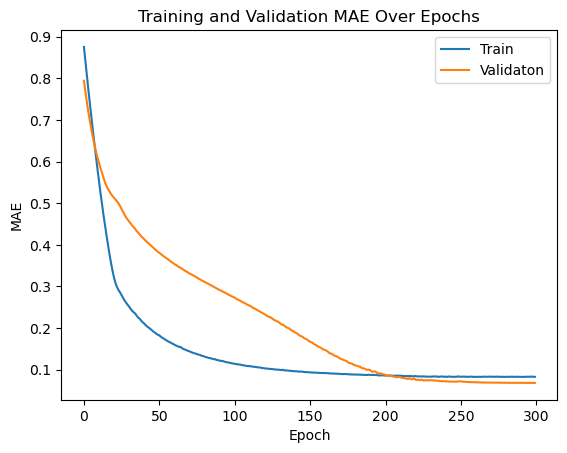

In [28]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validaton")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation MAE Over Epochs")
plt.legend()
plt.show()

In [29]:
coloumns_name = ["a", "b", "rho", "m", "sigma"]

In [30]:
model_y_predictions = pd.DataFrame(model_y_predictions.reshape(-1,5), columns=coloumns_name)
model_y_predictions

,a,b,rho,m,sigma
0,0.118233,4.470906,-0.285487,-0.008270,0.013384
1,-0.086279,3.942443,-0.125094,0.007295,0.061806
2,-22.926786,23.757359,-0.246355,-0.234823,0.992189
3,-1.234843,4.629407,-0.003449,0.032166,0.312707
4,-2.258620,3.870810,0.005377,0.048440,0.646892
...,...,...,...,...,...
847,-0.825453,1.191244,-0.319252,-0.374128,0.996353
848,-0.483978,0.813447,0.009642,-0.006127,1.001296
849,-0.403387,0.759139,-0.131159,-0.173699,1.001296
850,0.019119,0.429290,0.434110,0.647038,0.998316


In [31]:
y_test = pd.DataFrame(y_test.reshape(-1,5), columns=coloumns_name)
y_test

,a,b,rho,m,sigma
0,0.101246,4.615045,-0.281809,-0.010135,0.012492
1,-0.037243,3.869620,-0.151607,0.005576,0.057048
2,-22.514044,23.445426,-0.239843,-0.234800,1.000000
3,-1.225167,4.684293,-0.003908,0.031827,0.319719
4,-2.996107,4.415602,0.045797,0.080488,0.742053
...,...,...,...,...,...
847,-0.806502,1.191507,-0.350800,-0.419225,1.000000
848,-0.520728,0.858675,-0.046216,-0.052637,1.000000
849,-0.403187,0.758455,-0.109753,-0.136756,1.000000
850,0.018290,0.435681,0.453109,0.683348,1.000000


In [32]:
flat_y_test_indexes = [item for sublist in y_test_indexes for item in sublist]

In [33]:
model_y_predictions['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
model_y_predictions['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
model_y_predictions.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118233   4.470906 -0.285487   
                    0.008219          -0.086279   3.942443 -0.125094   
                    0.010959         -22.926786  23.757359 -0.246355   
                    0.019178          -1.234843   4.629407 -0.003449   
                    0.038356          -2.258620   3.870810  0.005377   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.825453   1.191244 -0.319252   
                    0.249315          -0.483978   0.813447  0.009642   
                    0.383562          -0.403387   0.759139 -0.131159   
                    0.632877           0.019119   0.429290  0.434110   
                    0.882192           0.191688   0.227053  0.203499   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 18:42:50 0.005479         -0.008270  0.013384  
                    0.008219          0.007295  0.061806  
                    0.010959         -0.234823  0.992189  
                    0.019178          0.032166  0.312707  
                    0.038356          0.048440  0.646892  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.374128  0.996353  
                    0.249315         -0.006127  1.001296  
                    0.383562         -0.173699  1.001296  
                    0.632877          0.647038  0.998316  
                    0.882192          0.276367  0.997944  

[852 rows x 5 columns]

In [544]:
y_test[0:50]

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.101246   4.615045 -0.281809   
                    0.008219          -0.037243   3.869620 -0.151607   
                    0.010959         -22.514044  23.445426 -0.239843   
                    0.019178          -1.225167   4.684293 -0.003908   
                    0.038356          -2.996107   4.415602  0.045797   
                    0.057534          -0.899014   2.309718 -0.082476   
                    0.134247          -1.540031   1.878196 -0.217400   
                    0.210959          -0.797457   1.130343 -0.205634   
                    0.249315          -0.479590   0.813972 -0.034861   
                    0.383562          -0.416888   0.768983 -0.114857   
                    0.632877          -0.004729   0.408812  0.246021   
                    0.882192           0.202081   0.220824  0.229322   
2024-08-10 18:45:35 0.005479           0.115405   4.503558 -0.276648   
                    0.008219          -0.075282   4.090921 -0.172358   
                    0.010959         -22.361803  23.286399 -0.239436   
                    0.019178          -1.193081   4.653163 -0.019981   
                    0.038356          -3.368764   4.647263  0.056199   
                    0.057534          -0.895760   2.302084 -0.073700   
                    0.134247          -1.544114   1.885451 -0.226766   
                    0.210959          -0.790496   1.123917 -0.205281   
                    0.249315          -0.507616   0.844327 -0.077030   
                    0.383562          -0.419081   0.770958 -0.110792   
                    0.632877           0.015083   0.405899  0.352371   
                    0.882192           0.202956   0.220888  0.236744   
2024-08-10 18:48:21 0.005479           0.118679   4.475579 -0.268324   
                    0.008219          -0.090735   4.134796 -0.144562   
                    0.010959         -12.850170  19.266090  0.374556   
                    0.019178          -1.299011   4.776735 -0.014774   
                    0.038356          -3.148201   4.517912  0.060712   
                    0.057534          -1.118692   2.468405 -0.088419   
                    0.134247          -1.541099   1.879545 -0.219486   
                    0.210959          -0.792651   1.123796 -0.199648   
                    0.249315          -0.455004   0.789550  0.015836   
                    0.383562          -0.417108   0.768838 -0.111122   
                    0.632877          -0.005164   0.408941  0.240953   
                    0.882192           0.203102   0.221137  0.240856   
2024-08-10 18:51:05 0.005479           0.124413   4.427707 -0.266052   
                    0.008219          -0.081947   4.139413 -0.173687   
                    0.010959         -11.521325  18.654212  0.395029   
                    0.019178          -1.233402   4.704528 -0.007153   
                    0.038356          -3.593970   4.798634  0.077144   
                    0.057534          -0.965302   2.356796 -0.080658   
                    0.134247          -1.545369   1.885345 -0.225241   
                    0.210959          -0.801679   1.142755 -0.243828   
                    0.249315          -0.426075   0.761306  0.066052   
                    0.383562          -0.415035   0.766912 -0.114673   
                    0.632877           0.008059   0.405910  0.311766   
                    0.882192           0.201256   0.221350  0.230101   
2024-08-10 18:53:55 0.005479           0.119779   4.450656 -0.252687   
                    0.008219          -0.117015   4.251124 -0.123596   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.010135  0.012492   
                    0.008219          0.005576  0.057048   
                    0.010959         -0.234800  1.000000   
 

In [540]:
model_y_predictions.index.get_level_values(0).unique()

Index(['2024-08-10 18:42:50', '2024-08-10 18:45:35', '2024-08-10 18:48:21',
       '2024-08-10 18:51:05', '2024-08-10 18:53:55', '2024-08-10 18:56:45',
       '2024-08-10 18:59:36', '2024-08-10 19:02:27', '2024-08-10 19:05:13',
       '2024-08-10 19:08:04', '2024-08-10 19:10:52', '2024-08-10 19:13:47',
       '2024-08-10 19:16:39', '2024-08-10 19:19:34', '2024-08-10 19:22:24',
       '2024-08-10 19:25:10', '2024-08-10 19:27:58', '2024-08-10 19:30:43',
       '2024-08-10 19:33:39', '2024-08-10 19:36:25', '2024-08-10 19:39:15',
       '2024-08-10 19:42:02', '2024-08-10 19:44:48', '2024-08-10 19:47:39',
       '2024-08-10 19:50:29', '2024-08-10 19:53:20', '2024-08-10 19:56:11',
       '2024-08-10 19:58:58', '2024-08-10 20:01:45', '2024-08-10 20:04:34',
       '2024-08-10 20:07:19', '2024-08-10 20:10:04', '2024-08-10 20:12:54',
       '2024-08-10 20:15:42', '2024-08-10 20:18:31', '2024-08-10 20:21:20',
       '2024-08-10 20:24:14', '2024-08-10 20:27:00', '2024-08-10 20:29:47',
       '2024

In [34]:
y_test['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
y_test['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
y_test.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
y_test

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.101246   4.615045 -0.281809   
                    0.008219          -0.037243   3.869620 -0.151607   
                    0.010959         -22.514044  23.445426 -0.239843   
                    0.019178          -1.225167   4.684293 -0.003908   
                    0.038356          -2.996107   4.415602  0.045797   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 18:42:50 0.005479         -0.010135  0.012492  
                    0.008219          0.005576  0.057048  
                    0.010959         -0.234800  1.000000  
                    0.019178          0.031827  0.319719  
                    0.038356          0.080488  0.742053  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.419225  1.000000  
                    0.249315         -0.052637  1.000000  
                    0.383562         -0.136756  1.000000  
                    0.632877          0.683348  1.000000  
                    0.882192          0.298585  1.000000  

[852 rows x 5 columns]

In [35]:
model_y_predictions = model_y_predictions.join(param_data_moneyness[['moneyness']], how='left')
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118233   4.470906 -0.285487   
                    0.008219          -0.086279   3.942443 -0.125094   
                    0.010959         -22.926786  23.757359 -0.246355   
                    0.019178          -1.234843   4.629407 -0.003449   
                    0.038356          -2.258620   3.870810  0.005377   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.825453   1.191244 -0.319252   
                    0.249315          -0.483978   0.813447  0.009642   
                    0.383562          -0.403387   0.759139 -0.131159   
                    0.632877           0.019119   0.429290  0.434110   
                    0.882192           0.191688   0.227053  0.203499   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.008270  0.013384   
                    0.008219          0.007295  0.061806   
                    0.010959         -0.234823  0.992189   
                    0.019178          0.032166  0.312707   
                    0.038356          0.048440  0.646892   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.374128  0.996353   
                    0.249315         -0.006127  1.001296   
                    0.383562         -0.173699  1.001296   
                    0.632877          0.647038  0.998316   
                    0.882192          0.276367  0.997944   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [36]:
y_test = y_test.join(param_data_moneyness[['moneyness']], how='left')
y_test

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.101246   4.615045 -0.281809   
                    0.008219          -0.037243   3.869620 -0.151607   
                    0.010959         -22.514044  23.445426 -0.239843   
                    0.019178          -1.225167   4.684293 -0.003908   
                    0.038356          -2.996107   4.415602  0.045797   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.010135  0.012492   
                    0.008219          0.005576  0.057048   
                    0.010959         -0.234800  1.000000   
                    0.019178          0.031827  0.319719   
                    0.038356          0.080488  0.742053   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.419225  1.000000   
                    0.249315         -0.052637  1.000000   
                    0.383562         -0.136756  1.000000   
                    0.632877          0.683348  1.000000   
                    0.882192          0.298585  1.000000   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [72]:
test_time_analyse = y_test.index.get_level_values(0).unique().to_list()[20]

In [73]:
maturity_analyse = y_test.index.get_level_values(1).unique().to_list()[10]

In [74]:
model_y_params = (model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][0], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][1], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][2], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][3], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_7200\2978534031.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_params = (model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][0], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][1], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][2], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][3], model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][4])


In [75]:
y_test_params = (y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][0], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][1], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][2], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][3], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_7200\2521297958.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_params = (y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][0], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][1], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][2], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][3], y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][4])


In [76]:
model_y_params

(0.013403179, 0.4368117, 0.4392264, 0.6483859, 0.9983158)

In [77]:
y_test_params

(0.0137099605722668,
 0.4302356741833589,
 0.422558261254478,
 0.6196873297147959,
 1.0)

In [78]:
model_y_log_money = model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_7200\2694831719.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_log_money = model_y_predictions.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][5]


In [79]:
y_test_log_money = y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_7200\115607597.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_log_money = y_test.xs(test_time_analyse, level="timestamp").loc[maturity_analyse][5]


In [80]:
%cd ..

c:\Users\Timi Durojaiye


In [81]:
from volatility_modelling.models.svi_model import SVIModel

In [82]:
svi = SVIModel()

In [83]:
model_y_params

(0.013403179, 0.4368117, 0.4392264, 0.6483859, 0.9983158)

In [84]:
svi.evaluate_svi(params=model_y_params, x=model_y_log_money)

array([0.57435968, 0.5012217 , 0.45722771, 0.44196725, 0.43005195,
       0.42092817, 0.41418139, 0.40948986, 0.40659559, 0.40528563,
       0.40537969, 0.40672185, 0.40917482, 0.41693535, 0.42781646,
       0.44112044, 0.45626899, 0.47278603, 0.4902841 , 0.50845186,
       0.54586165, 0.58362134, 0.62090765, 0.67500139, 0.75890212])

In [85]:
model_ivs = np.sqrt(svi.evaluate_svi(params=model_y_params, x=model_y_log_money))

In [86]:
model_ivs

array([0.75786521, 0.70797012, 0.67618615, 0.66480618, 0.65578347,
       0.64878977, 0.64356926, 0.63991395, 0.63764849, 0.63662047,
       0.63669435, 0.63774748, 0.63966774, 0.64570531, 0.6540768 ,
       0.66416899, 0.67547686, 0.68759438, 0.7002029 , 0.71305811,
       0.7388245 , 0.76395114, 0.78797694, 0.82158468, 0.87114988])

In [87]:
ivs = np.sqrt(svi.evaluate_svi(params=y_test_params, x=y_test_log_money))

In [88]:
%matplotlib inline

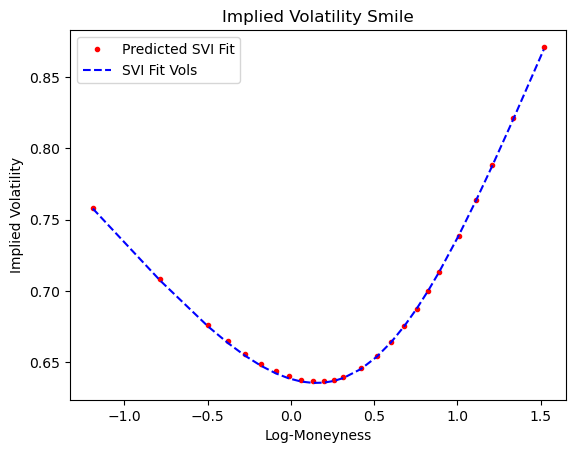

In [89]:
plt.plot(model_y_log_money, model_ivs, 'ro', label='Predicted SVI Fit', markersize=3)
plt.plot(y_test_log_money, ivs, 'b--', label='SVI Fit Vols')
plt.xlabel("Log-Moneyness")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile")
plt.legend()
plt.show()

In [92]:
%cd ml_models/

c:\Users\Timi Durojaiye\Desktop\Designing-optimal-options-market-making-systems-utilising-AI-for-implied-volatility-structures\ml_models


In [93]:
%cd ..

c:\Users\Timi Durojaiye\Desktop\Designing-optimal-options-market-making-systems-utilising-AI-for-implied-volatility-structures


In [94]:
from volatility_modelling.utilities.svi_surface_builder import SVISurfaceBuilder

In [95]:
class SVISurfaceBuilders:
    def __init__(self, parametised_data):
        self.parametised_data = parametised_data
        self.maturities = self.parametised_data.index.tolist()
        self.moneyness = self.parametised_data["moneyness"]
        self.svi_model = SVIModel()

    def construct_iv_surface(self):
        """
        Constructs an implied volatility surface (IVS)

        This method constructs an IVS from the calibrated SVI parameters using the original moneyness values.

        :return:
            - iv_surface (list of np.arrays) : IVS data stored as a list of arrays, one for each maturity
            - moneyness_list (list of np.arrays) : Original moneyness values for each maturity
        """

        iv_surface = []
        moneyness_list = []

        for i, T in enumerate(self.maturities):
            params = [self.parametised_data["a"].iloc[i], self.parametised_data["b"].iloc[i], self.parametised_data["rho"].iloc[i],
                      self.parametised_data["m"].iloc[i], self.parametised_data["sigma"].iloc[i]]
            
            current_moneyness = self.moneyness.iloc[i]
            current_iv = []

            for lm in current_moneyness:
                try:
                    svi_value = self.svi_model.evaluate_svi(params, lm)
                    iv = np.sqrt(svi_value) 
                    current_iv.append(iv)
                except Exception as e:
                    print(f"Error at T={T}, lm={lm}, params={params}: {str(e)}")
                    current_iv.append(np.nan)
            
            iv_surface.append(np.array(current_iv))
            moneyness_list.append(np.array(current_moneyness))

        return iv_surface, moneyness_list

    def plot_iv_surface(self, predicted):
        iv_surface, moneyness_list = self.construct_iv_surface()

        X_flat = np.concatenate([np.repeat(m, len(moneyness)) for m, moneyness in zip(self.maturities, moneyness_list)])
        Y_flat = np.concatenate(moneyness_list)
        Z_flat = np.concatenate(iv_surface)

        X_grid, Y_grid = np.meshgrid(np.linspace(min(Y_flat), max(Y_flat), 100),
                                     np.linspace(min(X_flat), max(X_flat), 100))

        Z_grid = griddata((Y_flat, X_flat), Z_flat, (X_grid, Y_grid), method='cubic')

        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap="coolwarm")

        ax.set_xlabel('Log Moneyness [ln(K/S)]')
        ax.set_ylabel('Time to Expiry (yrs)')
        ax.set_zlabel('IV')
        if predicted:
            ax.set_title('BTC Predicted Implied Volatility Surface')
        else:
            ax.set_title('BTC Implied Volatility Surface')
        fig.colorbar(surf, shrink=0.5, aspect=5)

        plt.show()

In [110]:
timing = model_y_predictions.index.get_level_values(0).unique().to_list()[45]

In [111]:
parametised_predicted_data = model_y_predictions.xs(timing, level="timestamp")
parametised_test_data = y_test.xs(timing, level="timestamp")

In [112]:
surface_builder = SVISurfaceBuilders(parametised_data=parametised_predicted_data)

In [113]:
%matplotlib qt 

In [114]:
%matplotlib inline

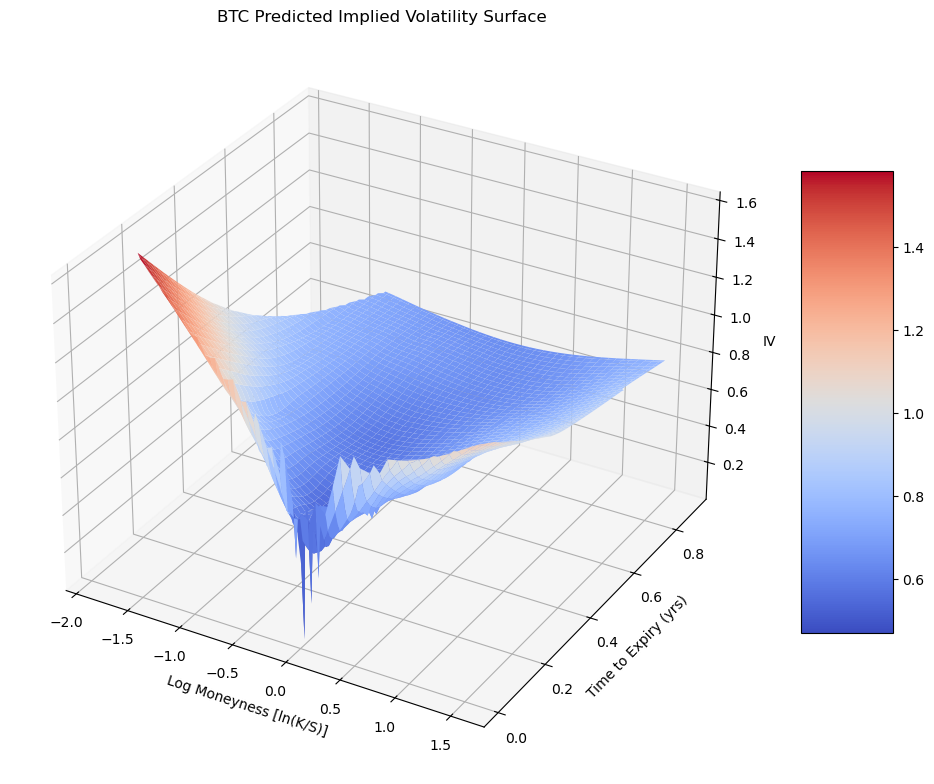

In [115]:
surface_builder.plot_iv_surface(predicted=True)

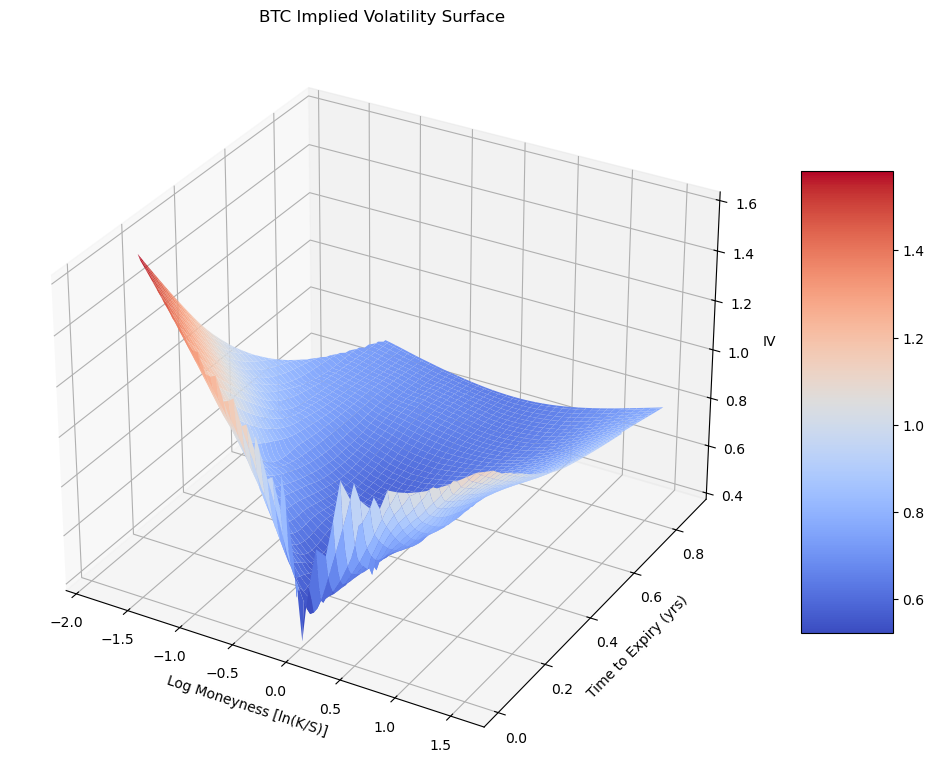

In [116]:
surface_builder = SVISurfaceBuilders(parametised_data=parametised_test_data)
surface_builder.plot_iv_surface(predicted=False)

In [117]:
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118233   4.470906 -0.285487   
                    0.008219          -0.086279   3.942443 -0.125094   
                    0.010959         -22.926786  23.757359 -0.246355   
                    0.019178          -1.234843   4.629407 -0.003449   
                    0.038356          -2.258620   3.870810  0.005377   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.825453   1.191244 -0.319252   
                    0.249315          -0.483978   0.813447  0.009642   
                    0.383562          -0.403387   0.759139 -0.131159   
                    0.632877           0.019119   0.429290  0.434110   
                    0.882192           0.191688   0.227053  0.203499   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.008270  0.013384   
                    0.008219          0.007295  0.061806   
                    0.010959         -0.234823  0.992189   
                    0.019178          0.032166  0.312707   
                    0.038356          0.048440  0.646892   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.374128  0.996353   
                    0.249315         -0.006127  1.001296   
                    0.383562         -0.173699  1.001296   
                    0.632877          0.647038  0.998316   
                    0.882192          0.276367  0.997944   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [573]:
test_time_analyse

'2024-08-10 19:39:15'

In [153]:
options_chain = pd.read_csv("data/options_market_data_cleaned.csv")
options_chain.drop(columns="Unnamed: 0", axis=1, inplace=True)
options_chain.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)

In [127]:
from option_pricing_model.black_scholes import BlackScholesModel

In [681]:
def compare_prices(options_chain, svi_data, timestamp, maturity, bm):
    options_filtered = options_chain[(options_chain.index.get_level_values(0) == timestamp) & (options_chain.index.get_level_values(1) == maturity)]
    svi_filtered = svi_data[(svi_data.index.get_level_values(0) == timestamp) & (svi_data.index.get_level_values(1) == maturity)]

    merged_data = pd.merge(options_filtered, svi_filtered, on=['timestamp', 'Time_To_Maturity'])
    
    merged_data['log_moneyness'] = np.log(merged_data['Strike_Price'] / merged_data['Coin_Price'])
    model_params = (merged_data["a"], merged_data["b"], merged_data["rho_y"], merged_data["m"], merged_data["sigma"])
    merged_data["ivs"] = np.sqrt(svi.evaluate_svi(params=model_params, x=merged_data['log_moneyness']))
    merged_data['svi_call_price'] = merged_data.apply(
        lambda row: bm.call_value(
            row['Coin_Price'], 
            row['Strike_Price'],
            row['Risk_Free_Rate'],
            row['ivs'],
            maturity),
            axis=1)

    merged_data['ae'] = np.abs(merged_data['Market_Price'] - merged_data['svi_call_price'])
    merged_data.reset_index(inplace=True)
    return merged_data[['timestamp', 'Time_To_Maturity', 'Strike_Price', 'Coin_Price', 'log_moneyness', 'Market_Price', 'svi_call_price', 'ae']]

In [682]:
def validation_analysis(options_chain, svi_data):
    bm = BlackScholesModel()
    results = []

    for timestamp in svi_data.index.get_level_values(0).unique():
        for maturity in svi_data.index.get_level_values(1).unique():
            result = compare_prices(options_chain, svi_data, timestamp, maturity, bm)
            results.append(result)
        
    
    return pd.concat(results, ignore_index=True)

In [683]:
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118233   4.470906 -0.285487   
                    0.008219          -0.086279   3.942443 -0.125094   
                    0.010959         -22.926786  23.757359 -0.246355   
                    0.019178          -1.234843   4.629407 -0.003449   
                    0.038356          -2.258620   3.870810  0.005377   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.825453   1.191244 -0.319252   
                    0.249315          -0.483978   0.813447  0.009642   
                    0.383562          -0.403387   0.759139 -0.131159   
                    0.632877           0.019119   0.429290  0.434110   
                    0.882192           0.191688   0.227053  0.203499   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.008270  0.013384   
                    0.008219          0.007295  0.061806   
                    0.010959         -0.234823  0.992189   
                    0.019178          0.032166  0.312707   
                    0.038356          0.048440  0.646892   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.374128  0.996353   
                    0.249315         -0.006127  1.001296   
                    0.383562         -0.173699  1.001296   
                    0.632877          0.647038  0.998316   
                    0.882192          0.276367  0.997944   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [684]:
summary_stats = validation_analysis(options_chain, model_y_predictions)

c:\Users\Timi Durojaiye\miniconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Timi Durojaiye\miniconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Timi Durojaiye\miniconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Timi Durojaiye\miniconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Timi Durojaiye\miniconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\T

In [685]:
summary_stats

,timestamp,Time_To_Maturity,Strike_Price,Coin_Price,log_moneyness,Market_Price,svi_call_price,ae
0,2024-08-10 18:42:50,0.005479,51000.0,60685.6955,-0.173882,9685.437002,9717.429673,31.992671
1,2024-08-10 18:42:50,0.005479,52000.0,60691.8149,-0.154565,8691.067894,8730.953672,39.885778
2,2024-08-10 18:42:50,0.005479,53000.0,60685.6955,-0.135416,7688.877620,7735.218146,46.340526
3,2024-08-10 18:42:50,0.005479,54000.0,60685.6957,-0.116724,6687.563666,6749.609382,62.045716
4,2024-08-10 18:42:50,0.005479,54500.0,60687.9303,-0.107544,6190.168891,6261.007526,70.838636
...,...,...,...,...,...,...,...,...
34004,2024-08-10 22:00:04,0.882192,160000.0,67551.0700,0.862290,2837.144940,3169.681100,332.536160
34005,2024-08-10 22:00:04,0.882192,180000.0,67552.8700,0.980046,2127.915405,2467.308041,339.392636
34006,2024-08-10 22:00:04,0.882192,200000.0,67524.7300,1.085823,1647.603412,1971.922008,324.318596
34007,2024-08-10 22:00:04,0.882192,250000.0,67551.2500,1.308574,1060.554625,1239.601597,179.046972


In [686]:
mae_per_expiry = summary_stats.groupby(["timestamp", "Time_To_Maturity"])["ae"].mean()

In [687]:
mae_per_expiry

timestamp            Time_To_Maturity
2024-08-10 18:42:50  0.005479            144.171465
                     0.008219             95.955240
                     0.010959             15.433734
                     0.019178             30.434076
                     0.038356             48.062566
                                            ...    
2024-08-10 22:00:04  0.210959            215.114857
                     0.249315            260.071307
                     0.383562            460.729324
                     0.632877            602.942175
                     0.882192            802.301596
Name: ae, Length: 852, dtype: float64

In [693]:
mae_per_expiry.xs(mae_per_expiry.index.get_level_values(0)[0], level="timestamp").index

Index([0.0054794520547945, 0.0082191780821917,  0.010958904109589,
       0.0191780821917808, 0.0383561643835616, 0.0575342465753424,
       0.1342465753424657,  0.210958904109589, 0.2493150684931507,
       0.3835616438356164, 0.6328767123287671, 0.8821917808219178],
      dtype='float64', name='Time_To_Maturity')

Text(0, 0.5, 'MAE')

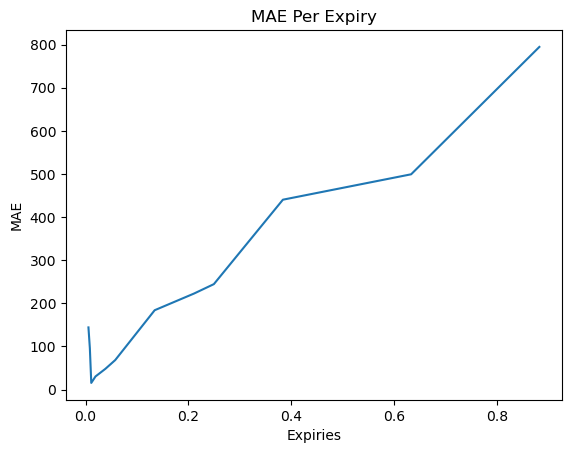

In [694]:
plt.plot(mae_per_expiry.xs(mae_per_expiry.index.get_level_values(0)[0], level="timestamp").index, mae_per_expiry.xs(mae_per_expiry.index.get_level_values(0)[0], level="timestamp").values)
plt.title("MAE Per Expiry")
plt.xlabel("Expiries")
plt.ylabel("MAE")

In [695]:
summary_stats = summary_stats.set_index(["timestamp", "Time_To_Maturity"])

In [696]:
summary_stats.index.get_level_values(0).unique()[0]

'2024-08-10 18:42:50'

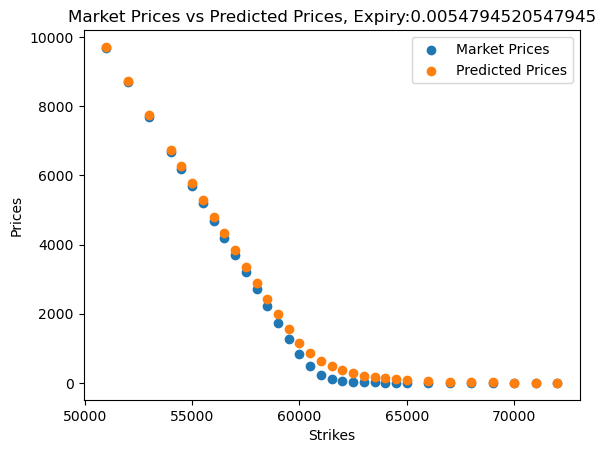

Spot price: 60685.6955


In [697]:
maturity_data = summary_stats.xs((summary_stats.index.get_level_values(0).unique()[0], summary_stats.index.get_level_values(1).unique()[0]))
plt.scatter(maturity_data["Strike_Price"], maturity_data["Market_Price"], label="Market Prices")
plt.scatter(maturity_data["Strike_Price"], maturity_data["svi_call_price"], label="Predicted Prices")
plt.legend()
plt.ylabel("Prices")
plt.xlabel("Strikes")
plt.title(f"Market Prices vs Predicted Prices, Expiry:{maturity_data.index.get_level_values(1).to_list()[0]}")
plt.show()
print("Spot price:", maturity_data["Coin_Price"].iloc[0])

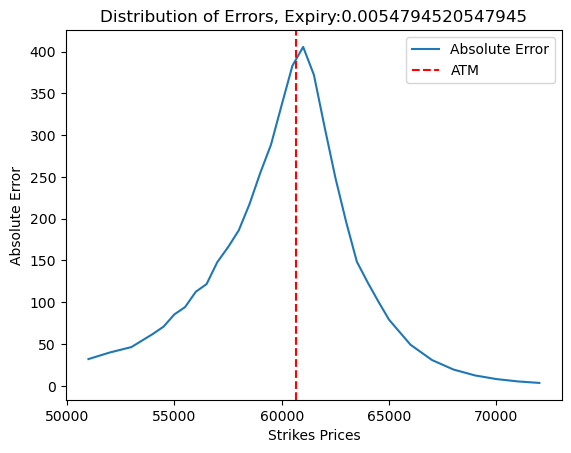

Spot price: 60685.6955


In [698]:
plt.plot(maturity_data["Strike_Price"], maturity_data["ae"], label="Absolute Error")
plt.axvline(maturity_data["Coin_Price"].iloc[0], color='red', linestyle='--', label="ATM")
plt.legend()
plt.ylabel("Absolute Error")
plt.xlabel("Strikes Prices")
plt.title(f"Distribution of Errors, Expiry:{maturity_data.index.get_level_values(1).to_list()[0]}")
plt.show()
print("Spot price:", maturity_data["Coin_Price"].iloc[0])

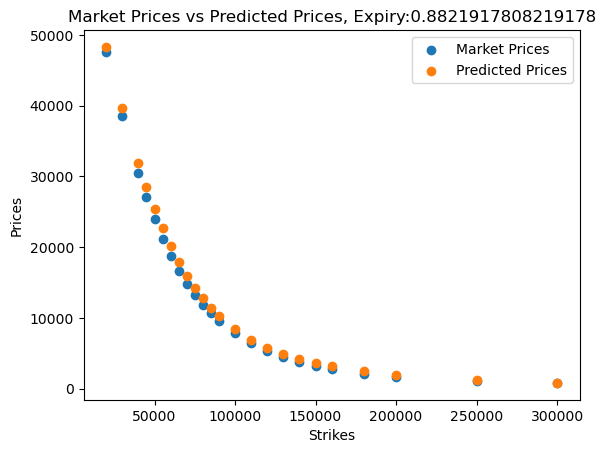

Spot price: 67195.07


In [699]:
maturity_data = summary_stats.xs((summary_stats.index.get_level_values(0).unique()[0], summary_stats.index.get_level_values(1).unique()[11]))
plt.scatter(maturity_data["Strike_Price"], maturity_data["Market_Price"], label="Market Prices")
plt.scatter(maturity_data["Strike_Price"], maturity_data["svi_call_price"], label="Predicted Prices")
plt.legend()
plt.ylabel("Prices")
plt.xlabel("Strikes")
plt.title(f"Market Prices vs Predicted Prices, Expiry:{maturity_data.index.get_level_values(1).to_list()[11]}")
plt.show()
print("Spot price:", maturity_data["Coin_Price"].iloc[0])

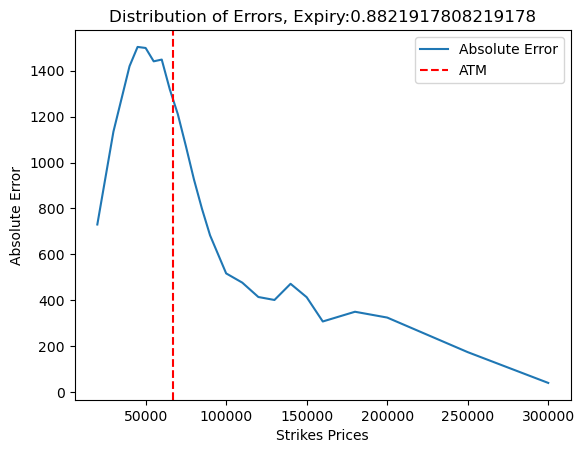

Spot price: 67195.07


In [700]:
plt.plot(maturity_data["Strike_Price"], maturity_data["ae"], label="Absolute Error")
plt.ylabel("Absolute Error")
plt.xlabel("Strikes Prices")
plt.axvline(maturity_data["Coin_Price"].iloc[0], color='red', linestyle='--', label="ATM")
plt.title(f"Distribution of Errors, Expiry:{maturity_data.index.get_level_values(1).to_list()[11]}")
plt.legend()
plt.show()
print("Spot price:", maturity_data["Coin_Price"].iloc[0])

In [701]:
summary_stats["log_moneyness"].min()

-1.8532463074643524

In [702]:
summary_stats["log_moneyness"].max()

1.5559091518972623

In [703]:
summary_stats["moneyness_classification"] = pd.cut(summary_stats["log_moneyness"], bins=[-float('inf'), 0.038, 1.038, float('inf')], labels=['ITM', 'ATM', 'OTM'])

summary_stats['maturity_classification'] = pd.cut(summary_stats.index.get_level_values(1), bins=[0, 0.08, 0.25, 0.5, float('inf')], labels=['Near Term', 'Short Term', 'Medium Term', 'Long Term'])

In [704]:
summary_stats.index.get_level_values(1).unique()

Index([0.0054794520547945, 0.0082191780821917,  0.010958904109589,
       0.0191780821917808, 0.0383561643835616, 0.0575342465753424,
       0.1342465753424657,  0.210958904109589, 0.2493150684931507,
       0.3835616438356164, 0.6328767123287671, 0.8821917808219178],
      dtype='float64', name='Time_To_Maturity')

In [705]:
summary_stats

Strike_Price  Coin_Price  log_moneyness  \
timestamp           Time_To_Maturity                                            
2024-08-10 18:42:50 0.005479               51000.0  60685.6955      -0.173882   
                    0.005479               52000.0  60691.8149      -0.154565   
                    0.005479               53000.0  60685.6955      -0.135416   
                    0.005479               54000.0  60685.6957      -0.116724   
                    0.005479               54500.0  60687.9303      -0.107544   
...                                            ...         ...            ...   
2024-08-10 22:00:04 0.882192              160000.0  67551.0700       0.862290   
                    0.882192              180000.0  67552.8700       0.980046   
                    0.882192              200000.0  67524.7300       1.085823   
                    0.882192              250000.0  67551.2500       1.308574   
                    0.882192              300000.0  67540.8000       1.491051   

                                      Market_Price  svi_call_price  \
timestamp           Time_To_Maturity                                 
2024-08-10 18:42:50 0.005479           9685.437002     9717.429673   
                    0.005479           8691.067894     8730.953672   
                    0.005479           7688.877620     7735.218146   
                    0.005479           6687.563666     6749.609382   
                    0.005479           6190.168891     6261.007526   
...                                            ...             ...   
2024-08-10 22:00:04 0.882192           2837.144940     3169.681100   
                    0.882192           2127.915405     2467.308041   
                    0.882192           1647.603412     1971.922008   
                    0.882192           1060.554625     1239.601597   
                    0.882192            810.489600      853.562127   

                                              ae moneyness_classification  \
timestamp           Time_To_Maturity                                        
2024-08-10 18:42:50 0.005479           31.992671                      ITM   
                    0.005479           39.885778                      ITM   
                    0.005479           46.340526                      ITM   
                    0.005479           62.045716                      ITM   
                    0.005479           70.838636                      ITM   
...                                          ...                      ...   
2024-08-10 22:00:04 0.882192          332.536160                      ATM   
                    0.882192          339.392636                      ATM   
                    0.882192          324.318596                      OTM   
                    0.882192          179.046972                      OTM   
                    0.882192           43.072527                      OTM   

                                     maturity_classification  
timestamp           Time_To_Maturity                          
2024-08-10 18:42:50 0.005479                       Near Term  
                    0.005479                       Near Term  
                    0.005479                       Near Term  
                    0.005479                       Near Term  
                    0.005479                       Near Term  
...                                                      ...  
2024-08-10 22:00:04 0.882192                       Long Term  
                    0.882192                       Long Term  
                    0.882192                       Long Term  
                    0.882192                       Long Term  
                    0.882192                       Long Term  

[34009 rows x 8 columns]

In [713]:
summary_stats.xs(summary_stats.index.get_level_values(0).unique()[0], level="timestamp")

,Strike_Price,Coin_Price,log_moneyness,Market_Price,svi_call_price,ae,moneyness_classification,maturity_classification
Time_To_Maturity,,,,,,,,
0.005479,51000.0,60685.6955,-0.173882,9685.437002,9717.429673,31.992671,ITM,Near Term
0.005479,52000.0,60691.8149,-0.154565,8691.067894,8730.953672,39.885778,ITM,Near Term
0.005479,53000.0,60685.6955,-0.135416,7688.877620,7735.218146,46.340526,ITM,Near Term
0.005479,54000.0,60685.6957,-0.116724,6687.563666,6749.609382,62.045716,ITM,Near Term
0.005479,54500.0,60687.9303,-0.107544,6190.168891,6261.007526,70.838636,ITM,Near Term
...,...,...,...,...,...,...,...,...
0.882192,160000.0,67200.5000,0.867493,2835.861100,3142.914594,307.053494,ATM,Long Term
0.882192,180000.0,67195.0700,0.985357,2096.486184,2445.971464,349.485280,ATM,Long Term
0.882192,200000.0,67189.6400,1.090798,1632.708252,1956.884853,324.176601,OTM,Long Term


In [712]:
summary_stats.xs(summary_stats.index.get_level_values(0).unique()[0], level="timestamp")[summary_stats.xs(summary_stats.index.get_level_values(0).unique()[0], level="timestamp")["moneyness_classification"] == "OTM"]["ae"].describe()


count     14.000000
mean      72.050563
std       90.003961
min        0.226011
25%       10.122461
50%       41.999603
75%       89.258927
max      324.176601
Name: ae, dtype: float64

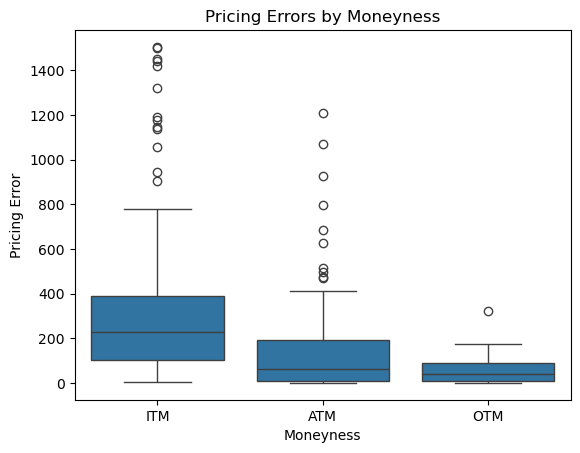

In [715]:
sns.boxplot(x='moneyness_classification', y='ae', data=summary_stats.xs(summary_stats.index.get_level_values(0).unique()[0], level="timestamp").reset_index(), showfliers=True)
plt.title('Pricing Errors by Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Pricing Error')
plt.show()

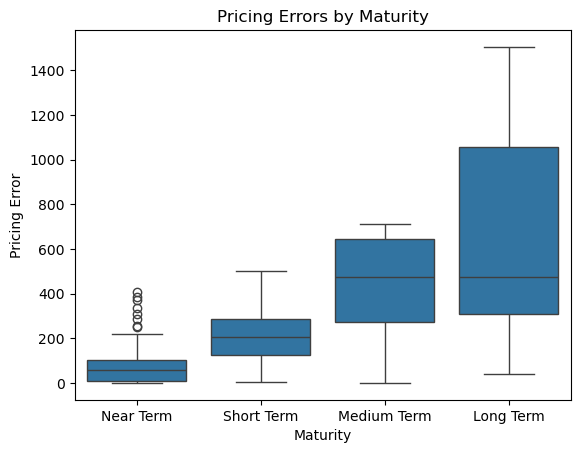

In [716]:
sns.boxplot(x='maturity_classification', y='ae', data=summary_stats.xs(summary_stats.index.get_level_values(0).unique()[0], level="timestamp").reset_index(), showfliers=True)
plt.title('Pricing Errors by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Pricing Error')
plt.show()

In [ ]:
plt.scatter(maturity_data["Strike_Price"], maturity_data["Market_Price"], label="Market Prices")
plt.scatter(maturity_data["Strike_Price"], maturity_data["svi_call_price"], label="Predicted Prices")
plt.legend()
plt.ylabel("Prices")
plt.xlabel("Strikes")
plt.title(f"Market Prices vs Predicted Prices, Expiry:{maturity_data.index.get_level_values(1).to_list()[0]}")
plt.show()
print("Spot price:", maturity_data["Coin_Price"].iloc[0])

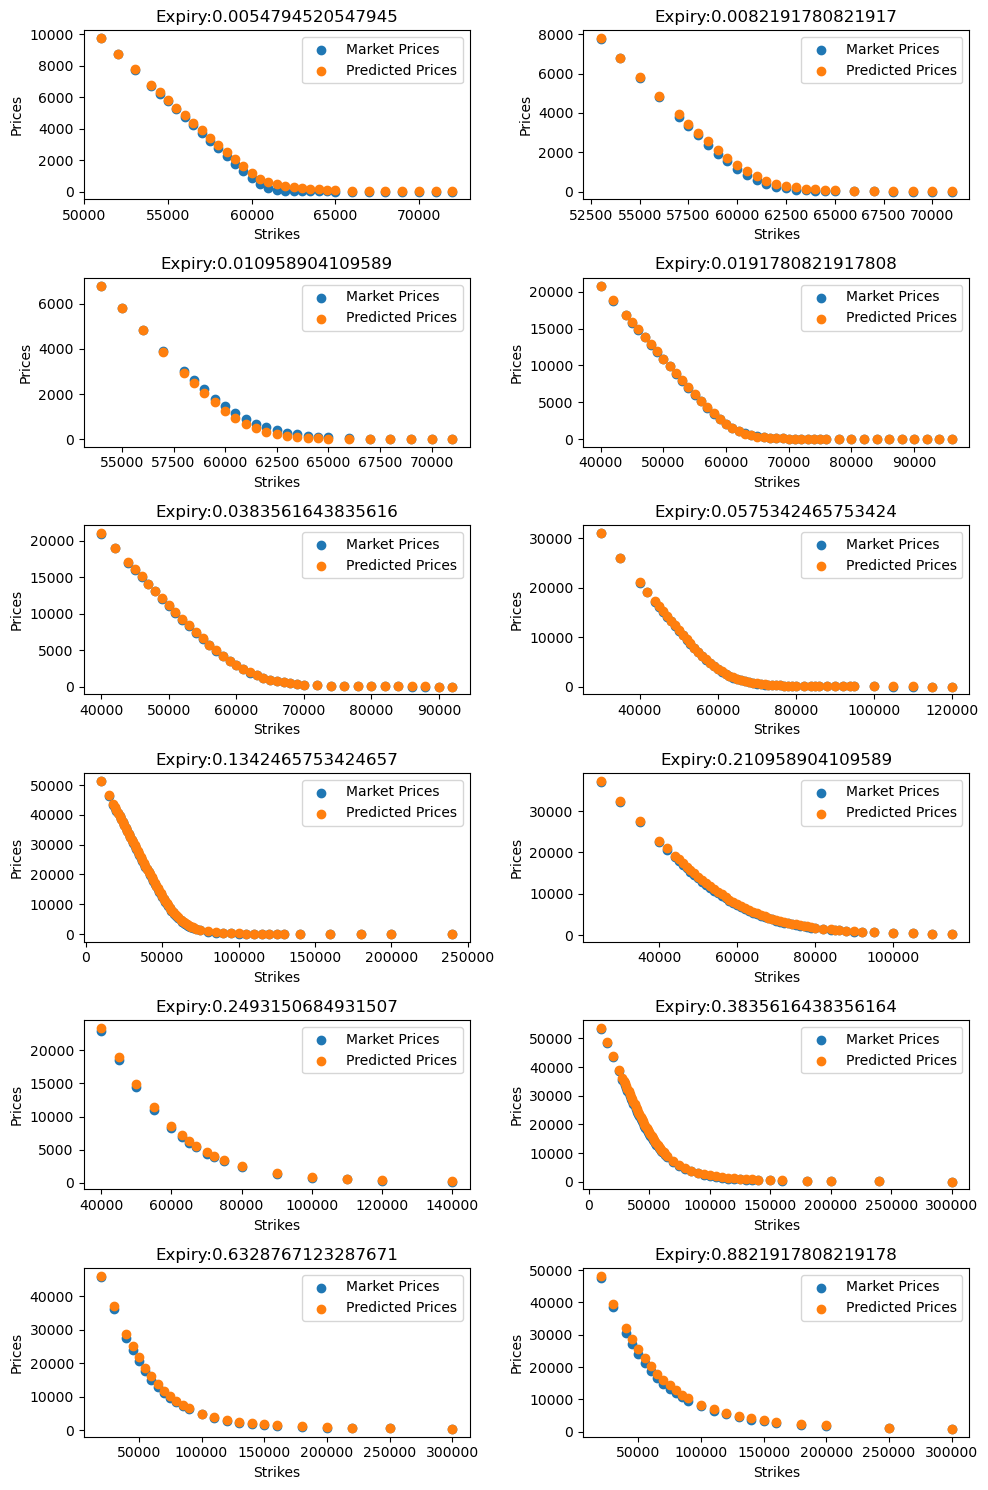

In [860]:
summary_time = summary_stats.index.get_level_values(0).unique()[3]
summary_data = summary_stats.xs(summary_time, level="timestamp")
grouped_summary_data = summary_data.groupby('Time_To_Maturity')


fig, axes = plt.subplots(6, 2, figsize=(10,15))
axes = axes.flatten()

for i, (time_to_maturity, group) in enumerate(grouped_summary_data):
    
    ax = axes[i]
    ax.scatter(group["Strike_Price"], group["Market_Price"], label="Market Prices")
    ax.scatter(group["Strike_Price"], group["svi_call_price"], label="Predicted Prices")
    ax.legend()

    ax.set_ylabel("Prices")
    ax.set_xlabel("Strikes")
    ax.set_title(f"Expiry:{time_to_maturity}")

plt.tight_layout()
plt.show()

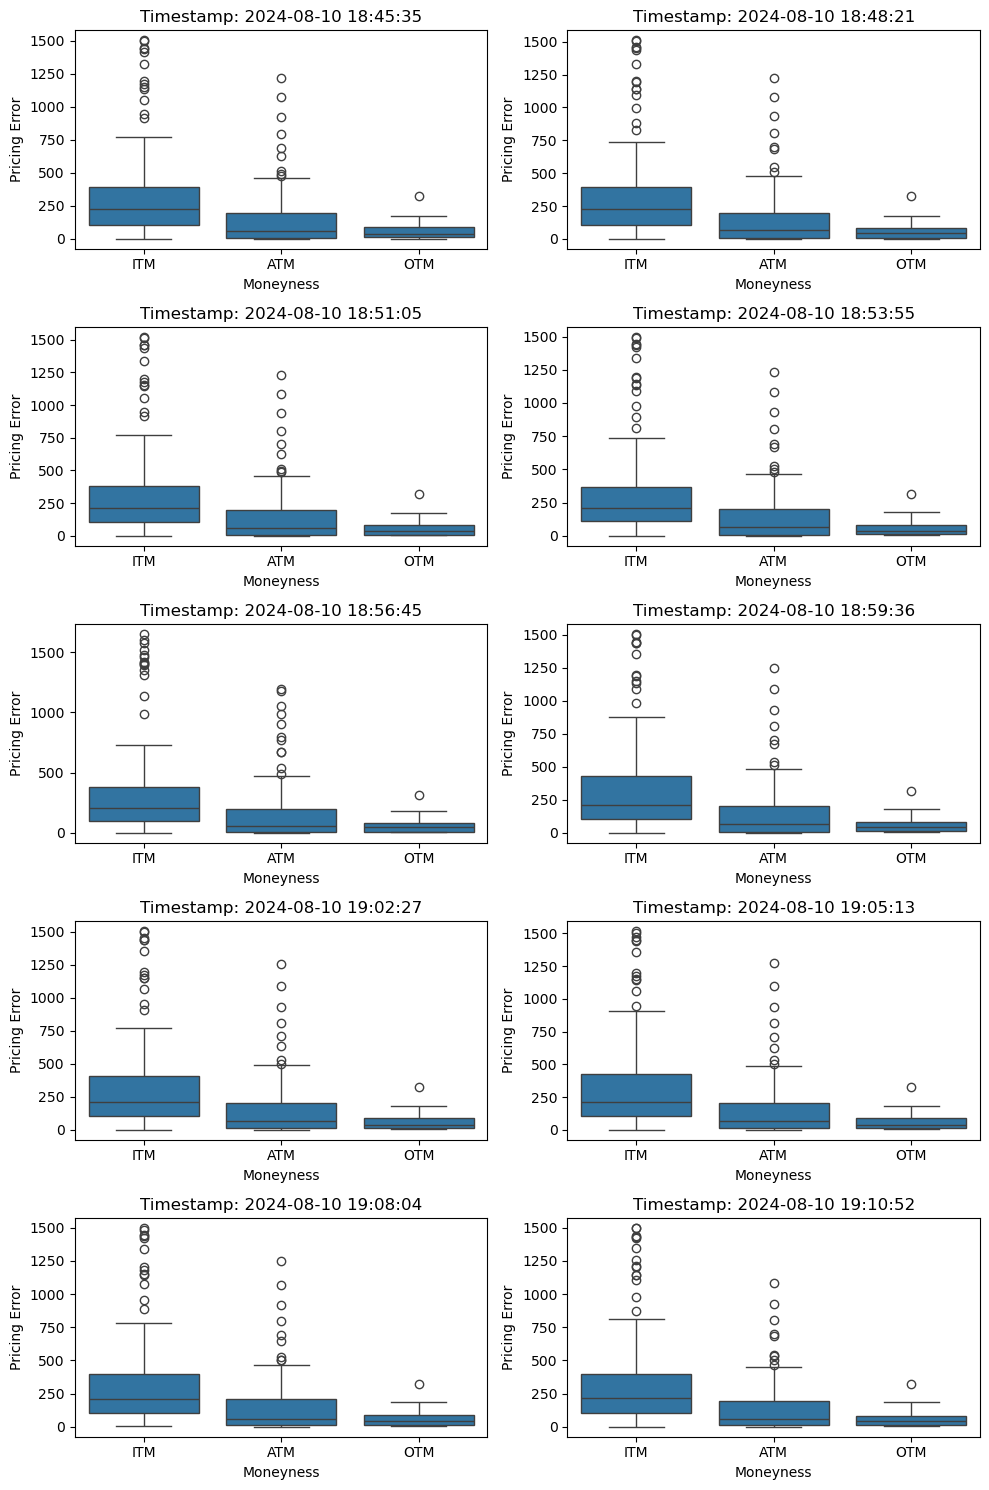

In [726]:
summary_timestamps = summary_stats.index.get_level_values(0).unique()
summary_timestamps = summary_timestamps[1:11]

num_timestamps = len(summary_timestamps)

fig, axes = plt.subplots(5, 2, figsize=(10, 15))
axes = axes.flatten()

for i, summary_timestamp in enumerate(summary_timestamps):
    data = summary_stats.xs(summary_timestamp, level="timestamp").reset_index()
    
    sns.boxplot(ax=axes[i], x='moneyness_classification', y='ae', data=data, showfliers=True)
    
    axes[i].set_title(f'Timestamp: {summary_timestamp}')
    axes[i].set_xlabel('Moneyness')
    axes[i].set_ylabel('Pricing Error')
    
plt.tight_layout()

plt.show()

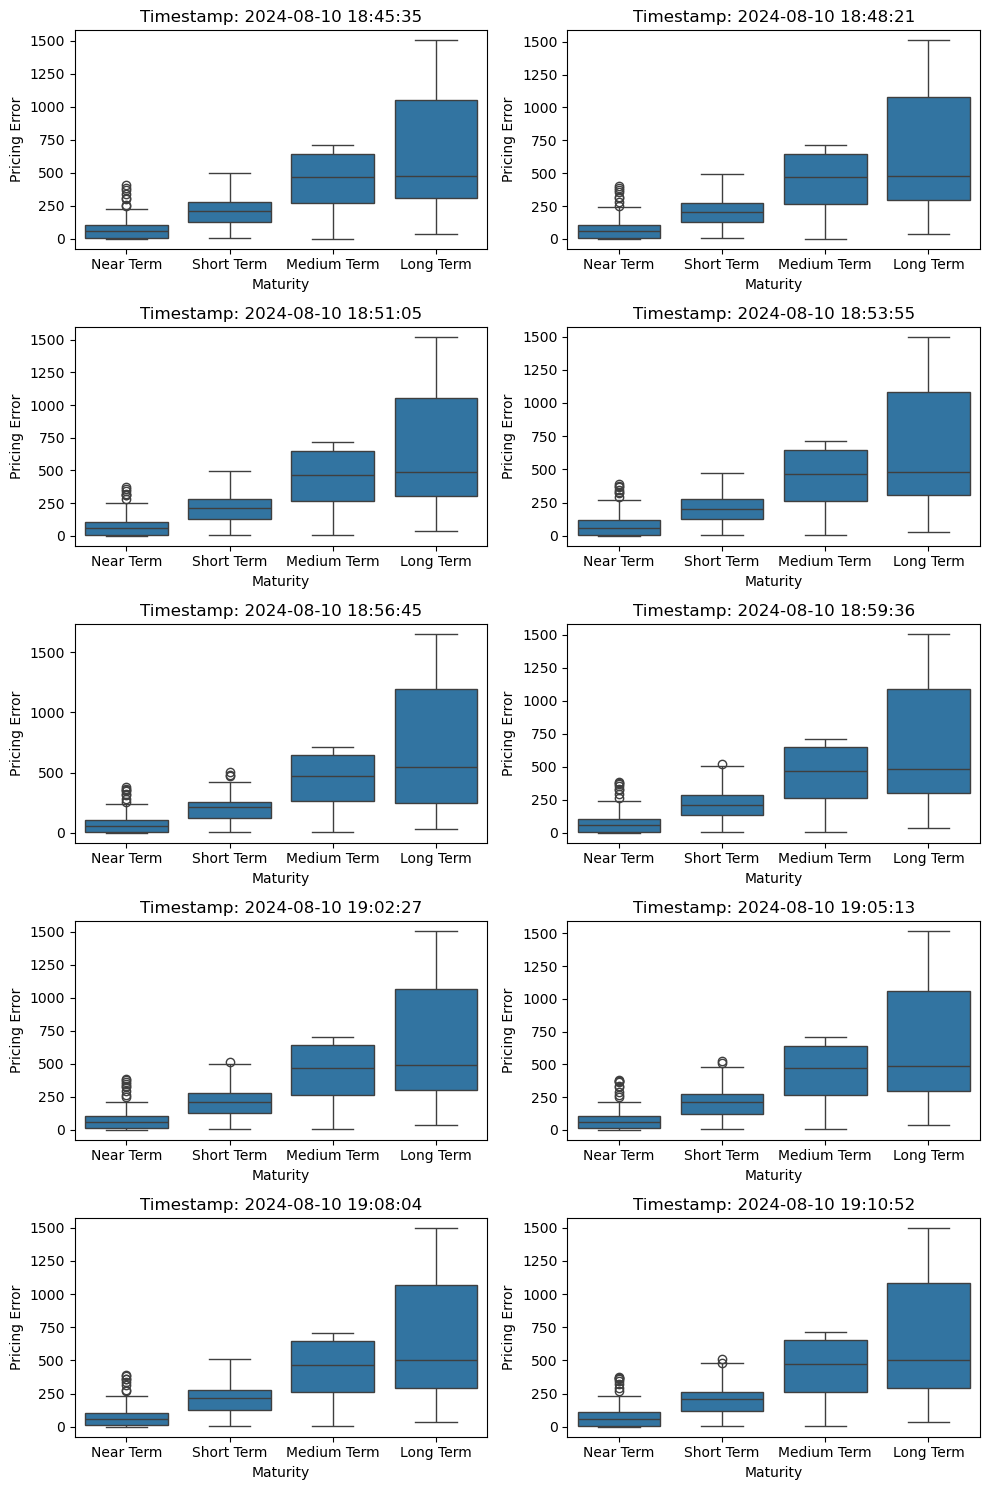

In [725]:
summary_timestamps = summary_stats.index.get_level_values(0).unique()
summary_timestamps = summary_timestamps[1:11]

num_timestamps = len(summary_timestamps)

fig, axes = plt.subplots(5, 2, figsize=(10, 15))
axes = axes.flatten()

for i, summary_timestamp in enumerate(summary_timestamps):
    data = summary_stats.xs(summary_timestamp, level="timestamp").reset_index()
    
    sns.boxplot(ax=axes[i], x='maturity_classification', y='ae', data=data, showfliers=True)
    
    axes[i].set_title(f'Timestamp: {summary_timestamp}')
    axes[i].set_xlabel('Maturity')
    axes[i].set_ylabel('Pricing Error')
    
plt.tight_layout()

plt.show()

In [747]:
class SurfaceComparison:
    def __init__(self, predicted_data, market_data):
        self.predicted_data = predicted_data
        self.market_data = market_data
        self.maturities = self.predicted_data.index.tolist()
        self.moneyness = self.predicted_data["moneyness"]
        self.svi_model = SVIModel()

    def construct_iv_surface(self, data):
        """
        Constructs an implied volatility surface (IVS)

        This method constructs an IVS from the calibrated SVI parameters using the original moneyness values.

        :return:
            - iv_surface (list of np.arrays) : IVS data stored as a list of arrays, one for each maturity
            - moneyness_list (list of np.arrays) : Original moneyness values for each maturity
        """

        iv_surface = []
        moneyness_list = []

        for i, T in enumerate(self.maturities):
            params = [data["a"].iloc[i], data["b"].iloc[i], data["rho"].iloc[i], data["m"].iloc[i], data["sigma"].iloc[i]]
            
            current_moneyness = self.moneyness.iloc[i]
            current_iv = []

            for lm in current_moneyness:
                try:
                    svi_value = self.svi_model.evaluate_svi(params, lm)
                    iv = np.sqrt(svi_value) 
                    current_iv.append(iv)
                except Exception as e:
                    print(f"Error at T={T}, lm={lm}, params={params}: {str(e)}")
                    current_iv.append(np.nan)
            
            iv_surface.append(np.array(current_iv))
            moneyness_list.append(np.array(current_moneyness))

        return iv_surface, moneyness_list

    def plot_iv_surface(self, time):
        market_iv_surface, market_moneyness_list = self.construct_iv_surface(self.market_data)
        predicted_iv_surface, predicted_moneyness_list = self.construct_iv_surface(self.predicted_data)

        market_X_flat = np.concatenate([np.repeat(m, len(moneyness)) for m, moneyness in zip(self.maturities, market_moneyness_list)])
        market_Y_flat = np.concatenate(market_moneyness_list)
        market_Z_flat = np.concatenate(market_iv_surface)


        predicted_X_flat = np.concatenate([np.repeat(m, len(moneyness)) for m, moneyness in zip(self.maturities, predicted_moneyness_list)])
        predicted_Y_flat = np.concatenate(predicted_moneyness_list)
        predicted_Z_flat = np.concatenate(predicted_iv_surface)

        market_X_grid, market_Y_grid = np.meshgrid(np.linspace(min(market_Y_flat), max(market_Y_flat), 100),
                                     np.linspace(min(market_X_flat), max(market_X_flat), 100))
        
        predicted_X_grid, predicted_Y_grid = np.meshgrid(np.linspace(min(predicted_Y_flat), max(predicted_Y_flat), 100),
                                     np.linspace(min(predicted_X_flat), max(predicted_X_flat), 100))

        market_Z_grid = griddata((market_Y_flat, market_X_flat), market_Z_flat, (market_X_grid, market_Y_grid), method='cubic')
        predicted_Z_grid = griddata((predicted_Y_flat, predicted_X_flat), predicted_Z_flat, (predicted_X_grid, predicted_Y_grid), method='cubic')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})

        surf1 = ax1.plot_surface(market_X_grid, market_Y_grid, market_Z_grid, cmap="coolwarm")
        ax1.set_xlabel('Log Moneyness [ln(K/S)]')
        ax1.set_ylabel('Time to Expiry (yrs)')
        ax1.set_zlabel('IV')
        ax1.set_title('BTC Market Implied Volatility Surface')
        fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

        surf2 = ax2.plot_surface(predicted_X_grid, predicted_Y_grid, predicted_Z_grid, cmap="coolwarm")
        ax2.set_xlabel('Log Moneyness [ln(K/S)]')
        ax2.set_ylabel('Time to Expiry (yrs)')
        ax2.set_zlabel('IV')
        ax2.set_title('BTC Predicted Implied Volatility Surface')
        fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

        fig.suptitle(f"Time: {time}")
        plt.tight_layout()
        plt.show()

In [794]:
timing = model_y_predictions.index.get_level_values(0).unique().to_list()[70]
print(timing)
parametised_predicted_data = model_y_predictions.xs(timing, level="timestamp")
parametised_test_data = y_test.xs(timing, level="timestamp")

2024-08-10 22:00:04


In [795]:
surface_comparison = SurfaceComparison(predicted_data=parametised_predicted_data, market_data=parametised_test_data)

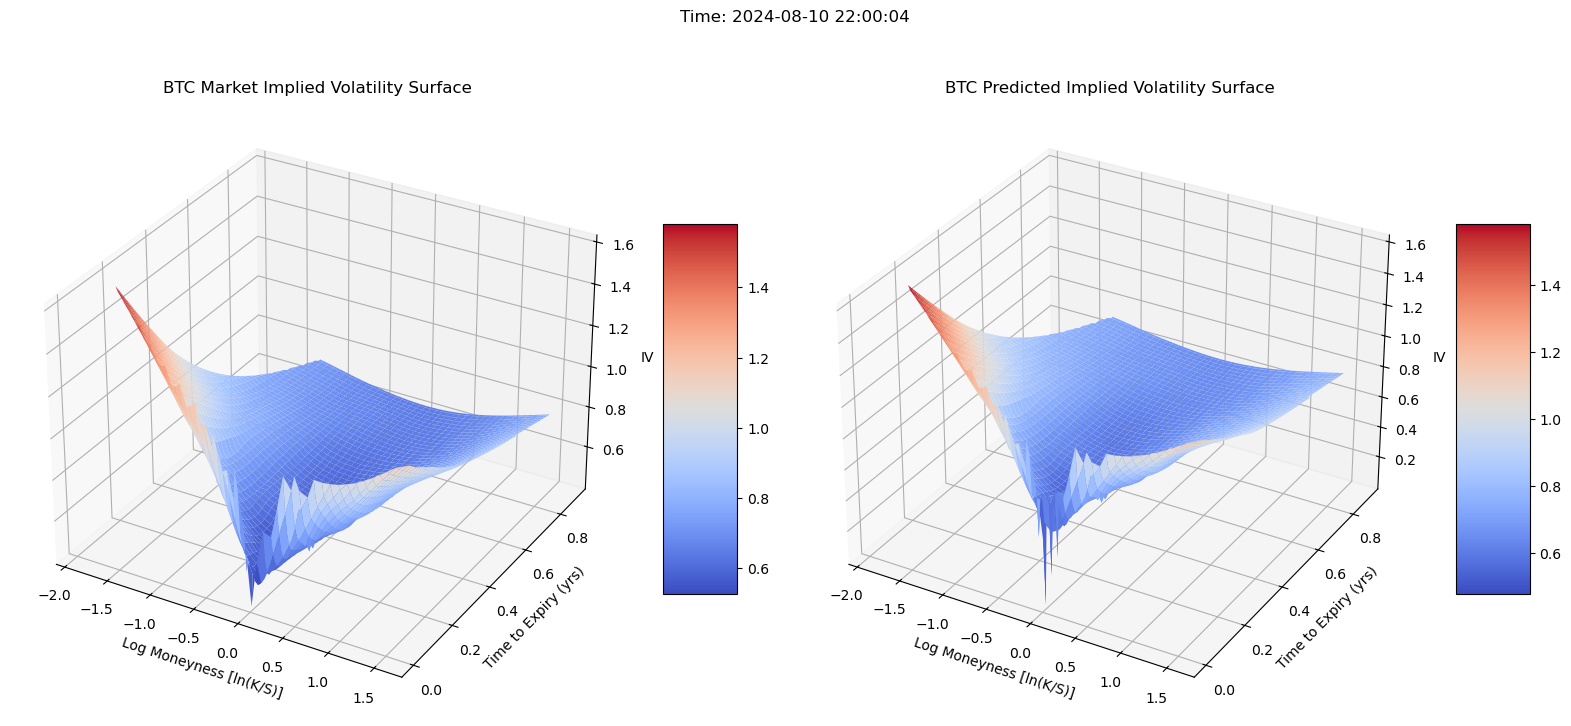

In [796]:
surface_comparison.plot_iv_surface(timing)

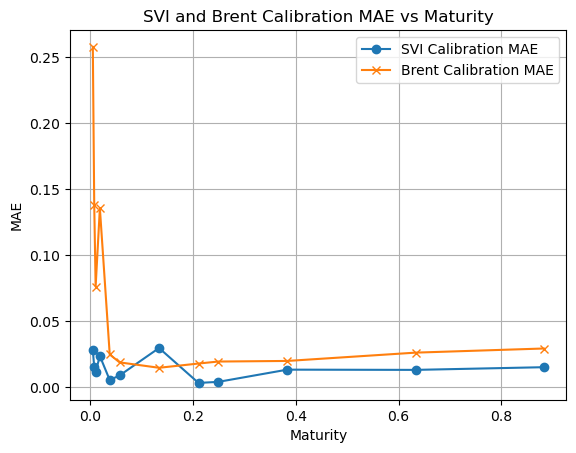

In [537]:
mae_data = {
    "Maturity": [0.0054794520547945, 0.0082191780821917, 0.010958904109589, 0.0191780821917808, 0.0383561643835616, 0.0575342465753424, 
                 0.1342465753424657, 0.210958904109589, 0.2493150684931507, 0.3835616438356164, 0.6328767123287671, 0.8821917808219178],

    "SVI Calibration MAE": [0.027618829145938658, 0.015040689254684072, 0.01152631253151099, 0.023344981968907923, 0.0051412308289311495, 
                            0.008624556582878938, 0.029449544979724344, 0.002960197984957463, 0.0037573028614403914, 0.0130337548765155, 
                            0.012851594074819714, 0.014890140454918025],
    
    "Brent Calibration MAE": [0.25792848924730005, 0.13799784892688147, 0.076105776848684, 0.1355418730785569, 0.02454478103396718, 
                              0.018539444720184154, 0.014454439276774499, 0.017674989879934922, 0.019181601328420964, 0.019636840376430355, 
                              0.025941006291835288, 0.029080011155243782]
}

mae_data_df = pd.DataFrame(mae_data)
plt.plot(mae_data_df['Maturity'], mae_data_df['SVI Calibration MAE'], label='SVI Calibration MAE', marker='o')
plt.plot(mae_data_df['Maturity'], mae_data_df['Brent Calibration MAE'], label='Brent Calibration MAE', marker='x')
plt.title('SVI and Brent Calibration MAE vs Maturity')
plt.xlabel('Maturity')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

Testing CPU Runtime of predictions

In [839]:
from tensorflow.keras.models import load_model
import gc
import time

In [805]:
surface_model = load_model("../saved_models/svi_convlstm.h5")

In [849]:
def prediction_test(surface_model=surface_model, y_scalers=y_scalers):
    gc.collect()
    start_time = time.perf_counter()

    model_input = np.expand_dims(X_test_scaled[15], axis=0)

    surface_prediction = surface_model.predict(model_input)
    scaled_predictions = surface_prediction

    for i, scaler in enumerate(y_scalers):
        surface_prediction_reshaped = surface_prediction[:, :,i].reshape(-1, surface_prediction.shape[1])
        surface_prediction[:, :, i]= scaler.inverse_transform(surface_prediction_reshaped).reshape(surface_prediction.shape[0], surface_prediction.shape[1])

    execution_time = time.perf_counter() - start_time
    return surface_prediction, execution_time

In [850]:
def run_benchmark(num_trials=100):
    
    execution_times = []

    for i in range(num_trials):
        surface_prediction, execution_time = prediction_test()
        execution_times.append(execution_time)

    average_time = np.mean(execution_times)
    std_time = np.std(execution_times)

    print("\nBenchmark Results:")
    print(f"Number of runs: {num_trials}")
    print(f"Average execution time: {average_time:.2f} seconds")
    print(f"Standard deviation: {std_time:.2f} seconds")
    print(f"Average time per expiry: {average_time / 12:.4f} seconds")


In [853]:
run_benchmark()

1/1 [==============================] - 0s 19ms/step

Benchmark Results:
Number of runs: 100
Average execution time: 0.05 seconds
Standard deviation: 0.00 seconds
Average time per expiry: 0.0040 seconds
